# Testing out Top 100 cpgs model on sexes separately

#### This notebook:
* Load the EWAS aging data selecting for whole blood data and the 2259n ranked cpgs by XGboost importance
* Fit Linear Regression, XGboost, Lasso, kNN and Ridge models predicting age using the top 100 cpgs
* Separate test data into male and female
* Test models on each separately


#### Conclusions:
* Linear models are more accurate on women than men (MAE 3.7 W, 4.0 M)
* Difference does not look systematic


#### Imports

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import os
import pickle
import warnings
warnings.simplefilter('ignore')
plt.rcdefaults()

#### Import our modules, 
* needs to have age_predict package the we created installed.

In [2]:
import age_predict.Loading_EWAS_Aging_Data as le
import age_predict.Regression as rg
import age_predict.Pickle_unpickle as pu

In [3]:
# View working directory
os.getcwd()

'/Users/dcox/Desktop/EWAS-organized/blood/modeling_linear_XGboost'

#### Set paths

In [4]:
data_path = '../../data/'
cpg_path = '../saved_features/'
save_models_path = '../saved_models/'

#### Get Saved imputed whole blood data 2263 cpgs
* The dataframes imported here were created with the "blood_feature_selection_by_XGBoost_importance_scores_gender" notebook

In [5]:
df_train = pd.read_csv(data_path + 'df_train_ranked_gen.csv', index_col=0)
df_test = pd.read_csv(data_path +  'df_test_ranked_gen.csv', index_col=0)

#### Get Saved blood cpg rankings
* The list of top ranked cpgs imported here was created with the "blood_feature_selection_by_XGBoost_importance_scores_gender" notebook and pickled

In [6]:
cpgs_XGboost_blood_ranked_gender = pu.get_pickled_object(cpg_path + 'cpgs_XGboost_blood_ranked_gender')

In [7]:
top_100 = cpgs_XGboost_blood_ranked_gender[:100]
top_1000 = cpgs_XGboost_blood_ranked_gender[:1000]

In [8]:
s = pd.Series(list(df_train.age) + list(df_test.age))

#### Looking at the age distributions in the data

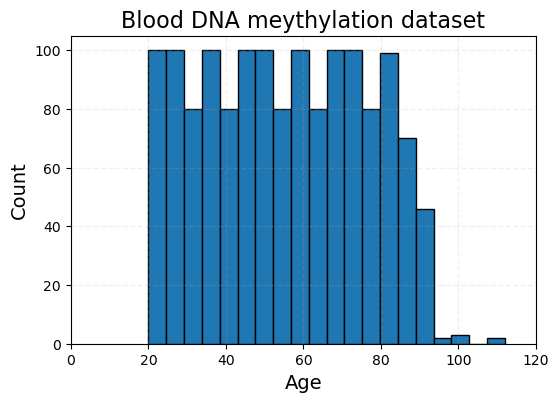

In [9]:
# Histogram of ages in train + test data
plt.figure(figsize=(6,4))
s.hist(bins=20,histtype='bar', ec='black' )
plt.xlabel('Age', fontsize=14)
plt.xlim(0,120)
plt.ylabel('Count', fontsize=14)
plt.grid(True, lw=1, ls = '--', alpha=0.2)
plt.title('Blood DNA meythylation dataset', fontsize=16)
plt.show()

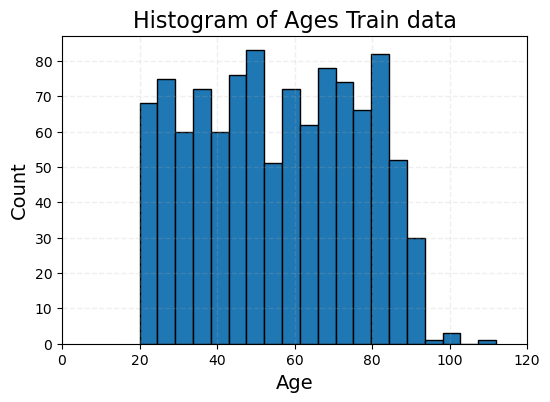

In [10]:
# Histogram of ages in train data
plt.figure(figsize=(6,4))
df_train.age.hist(bins=20,histtype='bar', ec='black' )
plt.xlabel('Age', fontsize=14)
plt.xlim(0,120)
plt.ylabel('Count', fontsize=14)
plt.grid(True, lw=1, ls = '--', alpha=0.2)
plt.title('Histogram of Ages Train data', fontsize=16)
plt.show()

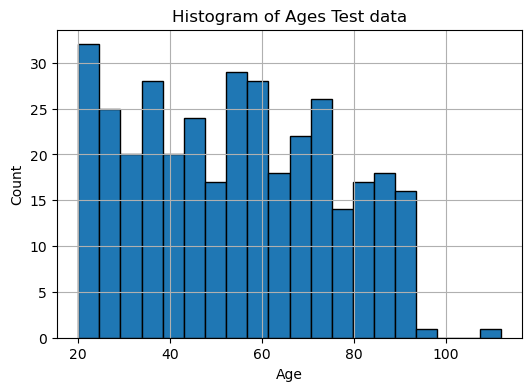

In [11]:
# Histogram of ages in test data
plt.figure(figsize=(6,4))
df_test.age.hist(bins=20, histtype='bar', ec='black')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Histogram of Ages Test data')
plt.show()

## 1 = Male, 0 = Female

In [12]:
df_train

,tissue,age,sex,cg11649376,cg14361627,cg04208403,cg07553761,cg16867657,cg08097417,cg22736354,cg04875128,cg06639320,cg21572722,cg24724428,cg00292135,cg09809672,cg17621438,cg23500537,cg23744638,cg02046143,cg19344626,cg16932827,cg24079702,cg04955333,cg08262002,cg07850154,cg07927379,cg10917602,cg22454769,cg23606718,cg16762684,cg10221746,cg05308819,cg21406967,cg08453194,cg01763090,cg23078123,cg18651026,cg06784991,cg03032497,cg25256723,cg03607117,cg09692396,cg19722847,cg01256539,cg07082267,cg25410668,cg18933331,cg00753885,cg25693132,...,cg03273183,cg08027484,cg08287288,cg07890600,cg05541640,cg11051055,cg02026449,cg12629083,cg05794117,cg02513379,cg22564695,cg10136576,cg00466121,cg09775533,cg03976754,cg11451477,cg12899747,cg22084515,cg11071207,cg15790767,cg15094119,cg26800155,cg03171300,cg17602444,cg05085255,cg08604905,cg03572680,cg01216438,cg20162206,cg13998369,cg15678844,cg08646025,cg17480278,cg02245119,cg05572153,cg10113526,cg11201837,cg19698668,cg04565337,cg20161645,cg04748546,cg25820971,cg02709717,cg00400104,cg04282723,cg26688678,cg18306747,cg11469540,cg24540315,cg01804382
GSM2334366,whole blood,94,0,0.483,0.187,0.538,0.433,0.875,0.173,0.349,0.312,0.594,0.591,0.531000,0.184,0.424,0.260,0.504,0.593,0.213,0.647000,0.835,0.597,0.660,0.490,0.362,0.130,0.752,0.770,0.294,0.011000,0.596,0.509,0.439,0.361,0.179,0.465,0.471,0.457,0.293,0.805,0.194,0.277,0.131,0.804,0.377,0.597,0.448,0.793,0.425,...,0.888,0.649,0.854,0.042000,0.202,0.226,0.221,0.012,0.743,0.121,0.903,0.013,0.027,0.107000,0.887,0.939,0.047000,0.982000,0.168,0.843,0.503,0.220,0.121,0.696,0.010000,0.015,0.789,0.297,0.256000,0.829,0.043000,0.023,0.217000,0.980,0.041,0.978,0.422,0.095000,0.872,0.007,0.746,0.172,0.691,0.087,0.863,0.437,0.260,0.109,0.919,0.285
GSM989863,whole blood,101,0,0.539,0.302,0.496,0.388,0.855,0.249,0.389,0.330,0.619,0.514,0.370000,0.201,0.315,0.164,0.513,0.340,0.150,0.573000,0.650,0.521,0.599,0.412,0.220,0.105,0.454,0.751,0.151,0.012000,0.556,0.459,0.272,0.343,0.246,0.471,0.457,0.435,0.307,0.554,0.096,0.201,0.070,0.544,0.338,0.652,0.332,0.691,0.430,...,0.852,0.592,0.829,0.038000,0.136,0.079,0.117,0.008,0.850,0.150,0.861,0.016,0.033,0.046000,0.920,0.941,0.064000,0.994000,0.153,0.913,0.599,0.351,0.133,0.629,0.016000,0.015,0.776,0.065,0.309000,0.865,0.062000,0.028,0.198000,0.978,0.042,0.967,0.244,0.088000,0.566,0.015,0.713,0.122,0.678,0.086,0.812,0.402,0.194,0.064,0.902,0.115
GSM1443696,whole blood,99,1,0.596,0.382,0.530,0.390,0.731,0.251,0.375,0.375,0.579,0.482,0.304000,0.212,0.250,0.214,0.584,0.426,0.126,0.354000,0.611,0.510,0.612,0.614,0.278,0.089,0.571,0.723,0.254,0.003000,0.615,0.437,0.281,0.357,0.264,0.560,0.507,0.335,0.329,0.714,0.180,0.233,0.054,0.579,0.325,0.663,0.350,0.767,0.765,...,0.937,0.650,0.847,0.060000,0.184,0.179,0.115,0.006,0.810,0.284,0.601,0.012,0.020,0.031000,0.869,0.965,0.215000,0.990000,0.162,0.907,0.646,0.046,0.191,0.591,0.013000,0.011,0.773,0.159,0.445000,0.866,0.152000,0.033,0.294000,0.985,0.029,0.957,0.344,0.221000,0.395,0.005,0.766,0.140,0.666,0.084,0.814,0.352,0.212,0.068,0.908,0.112
GSM1069241,whole blood,99,1,0.596,0.382,0.530,0.390,0.731,0.251,0.375,0.375,0.579,0.482,0.304000,0.212,0.250,0.214,0.584,0.426,0.126,0.354000,0.611,0.510,0.612,0.614,0.278,0.089,0.571,0.723,0.254,0.003000,0.615,0.437,0.281,0.357,0.264,0.560,0.507,0.335,0.329,0.714,0.180,0.233,0.054,0.579,0.325,0.663,0.350,0.767,0.765,...,0.937,0.650,0.847,0.060000,0.184,0.179,0.115,0.006,0.810,0.284,0.601,0.012,0.020,0.031000,0.869,0.965,0.215000,0.990000,0.162,0.907,0.646,0.046,0.191,0.591,0.013000,0.011,0.773,0.159,0.445000,0.866,0.152000,0.033,0.294000,0.985,0.029,0.957,0.344,0.221000,0.395,0.005,0.766,0.140,0.666,0.084,0.814,0.352,0.212,0.068,0.908,0.112
GSM1572442,whole blood,112,0,0.536,0.318,0.443,0.395,0.839,0.222,0.343,0.485,0.544,0.609,0.242941,0.291,0.451,0.449,0.668,0.410,0.227,0.708941,0.566,0.388,0.656,0.359,0.559,0.169,0.461,0.563,0.302,0.023000,0.555,0.396,0.249,0.236,0.305,0.507,0.552,0.287,0.370,0.486,0.053,0.223,0.035,0.652,0.336,0.746,0.396,0.698

In [13]:
df_test

,tissue,age,sex,cg11649376,cg14361627,cg04208403,cg07553761,cg16867657,cg08097417,cg22736354,cg04875128,cg06639320,cg21572722,cg24724428,cg00292135,cg09809672,cg17621438,cg23500537,cg23744638,cg02046143,cg19344626,cg16932827,cg24079702,cg04955333,cg08262002,cg07850154,cg07927379,cg10917602,cg22454769,cg23606718,cg16762684,cg10221746,cg05308819,cg21406967,cg08453194,cg01763090,cg23078123,cg18651026,cg06784991,cg03032497,cg25256723,cg03607117,cg09692396,cg19722847,cg01256539,cg07082267,cg25410668,cg18933331,cg00753885,cg25693132,...,cg03273183,cg08027484,cg08287288,cg07890600,cg05541640,cg11051055,cg02026449,cg12629083,cg05794117,cg02513379,cg22564695,cg10136576,cg00466121,cg09775533,cg03976754,cg11451477,cg12899747,cg22084515,cg11071207,cg15790767,cg15094119,cg26800155,cg03171300,cg17602444,cg05085255,cg08604905,cg03572680,cg01216438,cg20162206,cg13998369,cg15678844,cg08646025,cg17480278,cg02245119,cg05572153,cg10113526,cg11201837,cg19698668,cg04565337,cg20161645,cg04748546,cg25820971,cg02709717,cg00400104,cg04282723,cg26688678,cg18306747,cg11469540,cg24540315,cg01804382
GSM1345728,whole blood,38,0,0.638,0.108,0.645,0.246,0.606,0.112,0.240,0.129,0.388,0.359,0.162,0.053,0.464,0.265,0.399,0.697,0.314,0.726,0.912,0.312,0.785,0.534,0.330,0.040,0.671,0.475000,0.072,0.058,0.704,0.570,0.444,0.471,0.098,0.584,0.578,0.221,0.155,0.617,0.064,0.265,0.157,0.652,0.438,0.608,0.429,0.776,0.452,...,0.902,0.489,0.834,0.036,0.244,0.132,0.124,0.017,0.926,0.249,0.895,0.019,0.033,0.054,0.898,0.949,0.218000,0.986000,0.061,0.826,0.625,0.387,0.217,0.677,0.010,0.010,0.878,0.129,0.180000,0.890,0.097,0.029,0.244,0.990,0.039,0.951,0.226,0.096,0.557,0.007,0.747,0.173,0.695,0.077,0.860,0.465,0.235,0.075,0.925,0.144
GSM1425726,whole blood,79,1,0.569,0.125,0.557,0.345,0.847,0.102,0.368,0.317,0.674,0.770,0.610,0.096,0.393,0.137,0.664,0.538,0.292,0.330,0.773,0.612,0.613,0.487,0.205,0.064,0.705,0.818000,0.289,0.003,0.753,0.498,0.399,0.337,0.132,0.411,0.379,0.281,0.247,0.515,0.059,0.174,0.128,0.626,0.331,0.879,0.474,0.738,0.470,...,0.873,0.717,0.848,0.036,0.076,0.202,0.146,0.011,0.590,0.227,0.835,0.005,0.019,0.052,0.876,0.930,0.100000,0.984349,0.105,0.931,0.615,0.046,0.240,0.582,0.008,0.017,0.730,0.121,0.322000,0.897,0.048,0.020,0.136,0.979,0.029,0.944,0.506,0.160,0.203,0.020,0.730,0.144,0.708,0.074,0.839,0.366,0.177,0.053,0.889,0.112
GSM1886430,whole blood,24,1,0.749,0.103,0.607,0.151,0.464,0.093,0.224,0.089,0.345,0.361,0.172,0.060,0.637,0.555,0.380,0.856,0.312,0.843,0.935,0.166,0.818,0.718,0.597,0.037,0.755,0.345000,0.069,0.081,0.680,0.625,0.517,0.459,0.107,0.752,0.661,0.249,0.228,0.821,0.028,0.393,0.233,0.802,0.588,0.545,0.572,0.859,0.464,...,0.922,0.526,0.845,0.038,0.232,0.198,0.132,0.018,0.845,0.342,0.879,0.018,0.032,0.255,0.815,0.921,0.464000,0.980000,0.065,0.874,0.691,0.028,0.227,0.712,0.033,0.023,0.931,0.132,0.230000,0.868,0.119,0.031,0.330,0.986,0.031,0.973,0.306,0.134,0.311,0.004,0.781,0.182,0.709,0.099,0.838,0.412,0.265,0.107,0.891,0.198
GSM2337042,whole blood,25,0,0.719,0.087,0.652,0.177,0.458,0.059,0.173,0.034,0.292,0.334,0.137,0.055,0.696,0.354,0.352,0.857,0.347,0.856,0.890,0.195,0.790,0.752,0.444,0.030,0.723,0.346000,0.067,0.091,0.741,0.648,0.438,0.469,0.069,0.707,0.618,0.209,0.148,0.811,0.049,0.349,0.169,0.667,0.497,0.452,0.600,0.866,0.406,...,0.924,0.485,0.832,0.036,0.259,0.075,0.104,0.010,0.892,0.287,0.896,0.016,0.020,0.072,0.887,0.956,0.436000,0.984000,0.039,0.890,0.621,0.375,0.295,0.685,0.011,0.008,0.903,0.093,0.210000,0.893,0.057,0.013,0.224,0.981,0.045,0.969,0.301,0.129,0.359,0.015,0.757,0.177,0.710,0.086,0.774,0.423,0.281,0.061,0.936,0.157
GSM1886440,whole blood,23,1,0.590,0.172,0.653,0.122,0.509,0.058,0.285,0.302,0.339,0.394,0.263,0.027,0.685,0.575,0.488,0.897,0.358,0.792,0.942,0.261,0.847,0.728,0.594,0.011,0.693,0.267000,0.154,0.074,0.655,0.636,0.393,0.383,0.184,0.807,0.585,0.227,0.168,0.740,0.042,0.363,0.249,0.870,0.516,0.548,0.573,0.857,0.458,...,0.829,0.621,0.846,0.051,0.190,0.124,0.171,0.005,0.813,0.208,0.864,0.013,0.030,0.019,0.755,0.

#### Training Linear, XGboost, Ridge, Lasso models using the top 100 ranked cpgs

In [24]:
from sklearn.model_selection import train_test_split
X = df_train[top_100]
y = df_train.age
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 2021)

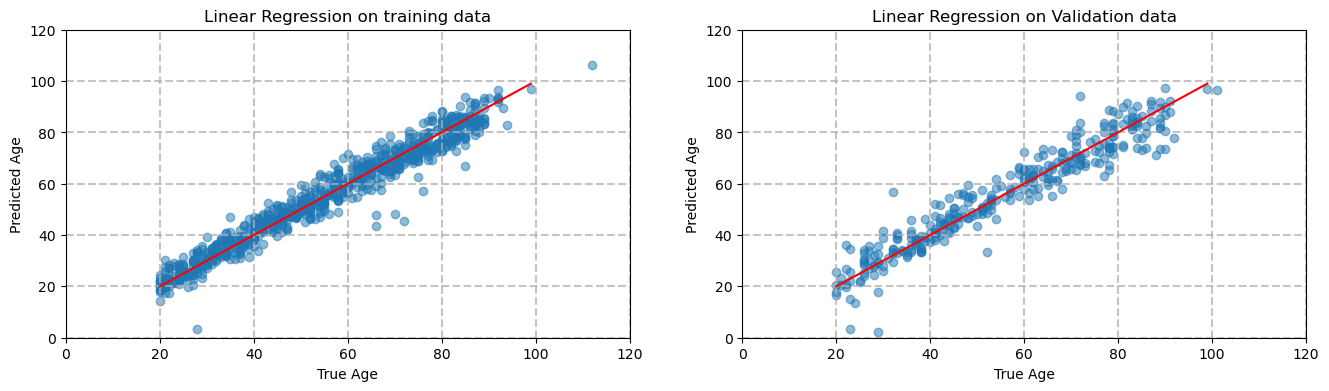

The rms on the training data is 4.431 years
The rms on the validation data is 5.977 years
The r^2 on the training data is 0.953
The r^2 on the validation data is 0.916
The MAe on the training data is 3.289 years
The MAE on the validation data is 4.336


In [25]:
wb_mod_100, rms_train, rms_test, r2_train, r2_test = rg.linear_regress(X_train, y_train, X_test, y_test, plot=True)

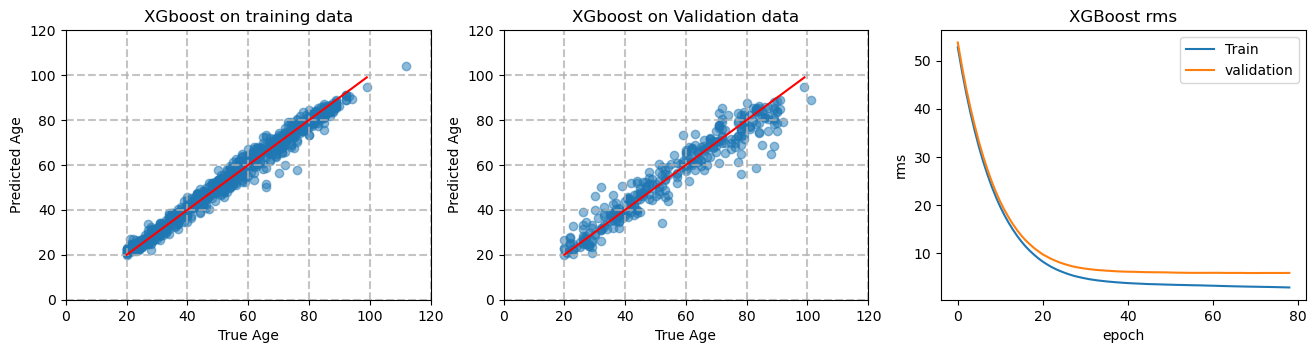

The number of training epochs was 79
The rms on the training data is 3.022 years
The rms on the validation data is 5.858 years
The r^2 on the training data is 0.978
The r^2 on the validation data is 0.919
The MAE on the training data is 2.282 years
The MAE on the validation data is 4.275 years


In [26]:
wb_mod_XG_100, rms_train, rms_test, r2_train, r2_test, feature_importances_ = rg.xgboost_regress(X_train, y_train, X_test, y_test, early_stopping_rounds=10)

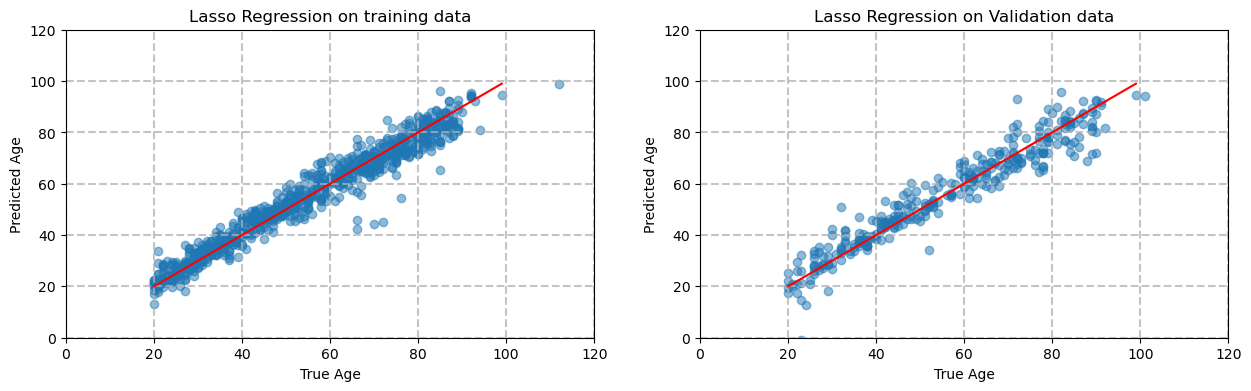

The rms on the training data is 4.716 years
The rms on the validation data is 5.935 years
The r^2 on the training data is 0.947
The r^2 on the validation data is 0.917
The MAE on the training data is 3.427 years
The MAE on the validation data is 4.182 years
Optimal alpha from CV = 0.01


In [27]:
wb_mod_lasso_100, rms_train, rms_test, r2_train, r2_test = rg.lassoCV_regress(X_train, y_train, X_test, y_test, plot=True, alphas=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5],cv=5)

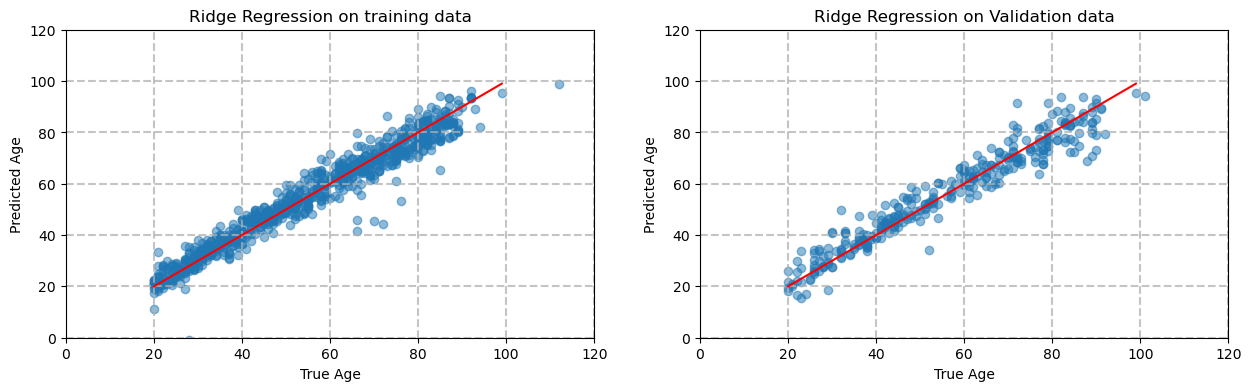

The rms on the training data is 4.708 years
The rms on the validation data is 5.746 years
The r^2 on the training data is 0.947
The r^2 on the validation data is 0.922
The MAE on the training data is 3.423 years
The MAE on the validation data is 4.031 years
Optimal alpha from CV = 1.0


In [28]:
wb_mod_ridge_100, rms_train, rms_test, r2_train, r2_test = rg.ridgeCV_regress(X_train, y_train, X_test, y_test, plot=True, alphas=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5],cv=5)

Best K = 15


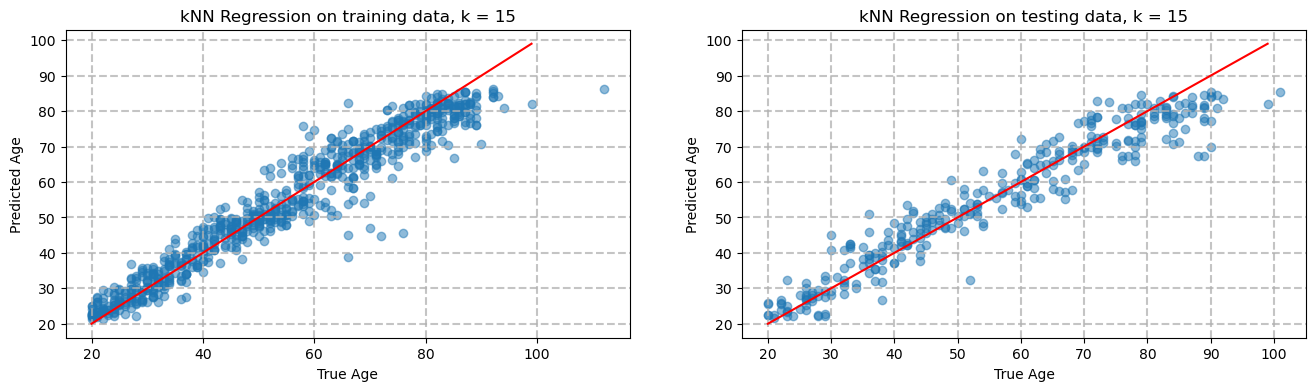

The rms on the training data is 5.363 years
The rms on the testing data is 5.786 years
The r^2 on the training data is 0.932
The r^2 on the testing data is 0.921
The MAe on the training data is 3.900 years
The MAE on the testing data is 4.334


In [29]:
wb_mod_kNN_100, rms_train, rms_test, r2_train, r2_test = rg.kNN_regress(X_train, y_train, X_test, y_test, plot=True, ks=[1, 2, 3, 5, 10, 15, 20, 30, 50],cv=5)

#### Testing Linear, XGboost, Ridge, Lasso models using the top 100 ranked cpgs on both sexes separately.

In [40]:
df_male = df_test[df_test.sex == 1]
df_female = df_test[df_test.sex == 0

In [41]:
X_test_male = df_male[top_100]
y_test_male = df_male.age

X_test_female = df_female[top_100]
y_test_female = df_female.age

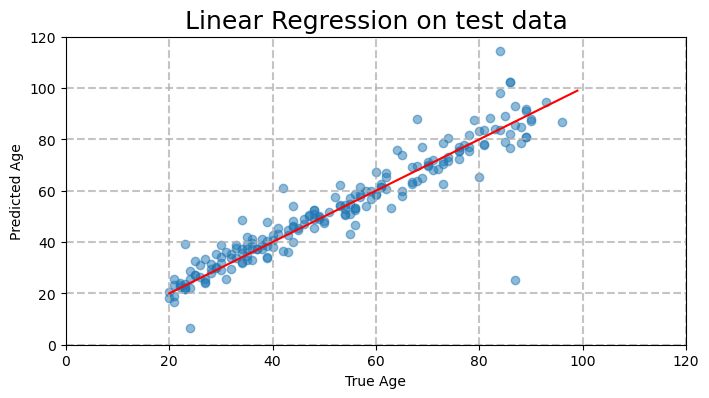

The MSE on Test data is 52.662 years
The rms on Test data is 7.257 years
The r^2 on Test data is 0.880
The mae on Test data is 4.245 years
The correlation on the Test data true-predicted is 0.941


In [30]:
preds, MSE, rms, r2, MAE, r_corr = rg.test_model_on_heldout_data(X_test_male, y_test_male, wb_mod_100, mtype='Linear Regression', figsize=(8,4))

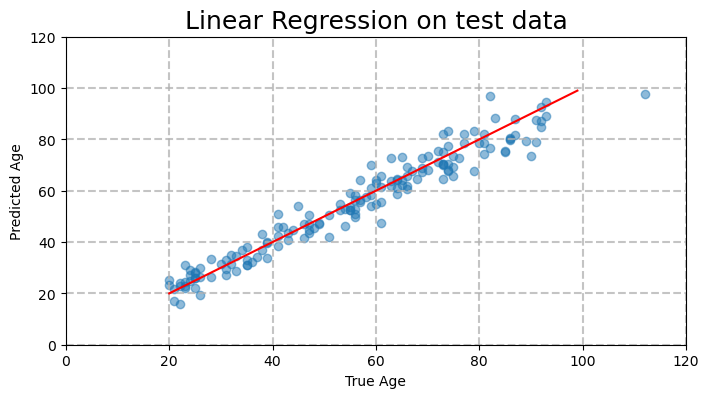

The MSE on Test data is 25.412 years
The rms on Test data is 5.041 years
The r^2 on Test data is 0.944
The mae on Test data is 3.868 years
The correlation on the Test data true-predicted is 0.973


In [31]:
preds, MSE, rms, r2, MAE, r_corr = rg.test_model_on_heldout_data(X_test_female, y_test_female, wb_mod_100, mtype='Linear Regression', figsize=(8,4))

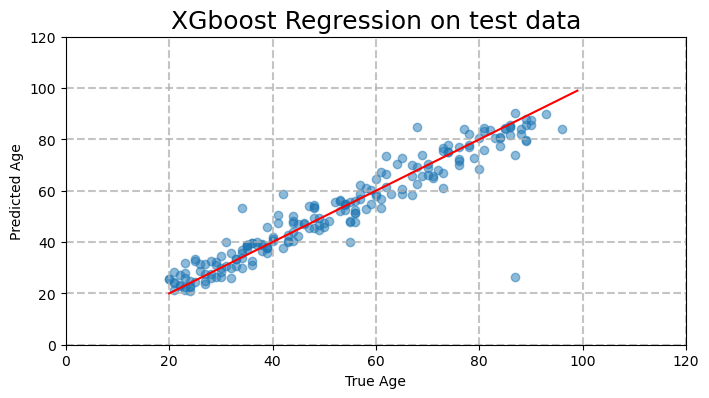

The MSE on Test data is 43.372 years
The rms on Test data is 6.586 years
The r^2 on Test data is 0.901
The mae on Test data is 4.084 years
The correlation on the Test data true-predicted is 0.950


In [33]:
preds, MSE, rms, r2, MAE, r_corr = rg.test_model_on_heldout_data(X_test_male, y_test_male, wb_mod_XG_100, mtype='XGboost Regression', figsize=(8,4))

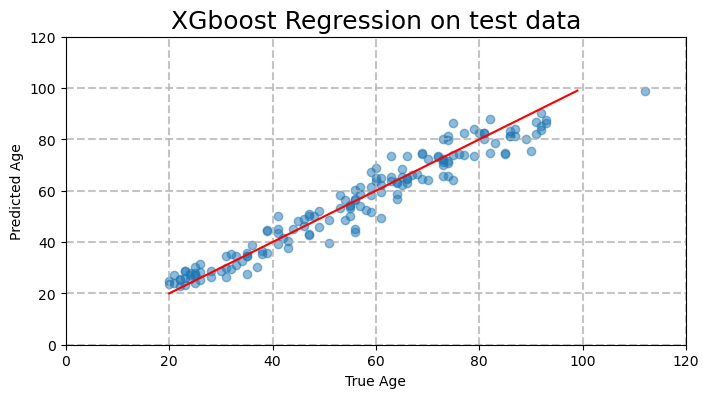

The MSE on Test data is 25.249 years
The rms on Test data is 5.025 years
The r^2 on Test data is 0.944
The mae on Test data is 4.008 years
The correlation on the Test data true-predicted is 0.973


In [34]:
preds, MSE, rms, r2, MAE, r_corr = rg.test_model_on_heldout_data(X_test_female, y_test_female, wb_mod_XG_100, mtype='XGboost Regression', figsize=(8,4))

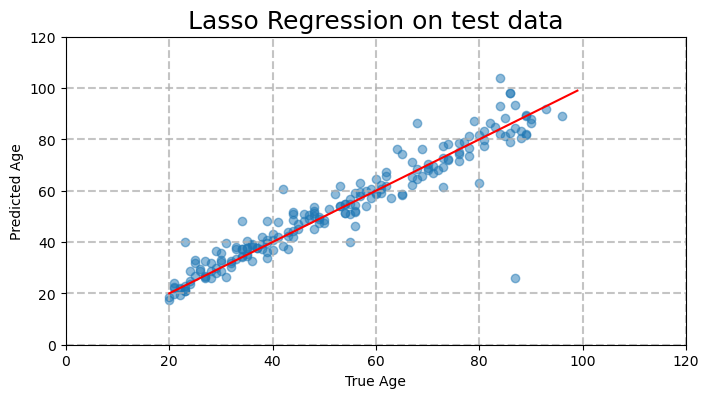

The MSE on Test data is 49.289 years
The rms on Test data is 7.021 years
The r^2 on Test data is 0.888
The mae on Test data is 4.072 years
The correlation on the Test data true-predicted is 0.944


In [35]:
preds, MSE, rms, r2, MAE, r_corr = rg.test_model_on_heldout_data(X_test_male, y_test_male, wb_mod_lasso_100, mtype='Lasso Regression', figsize=(8,4))

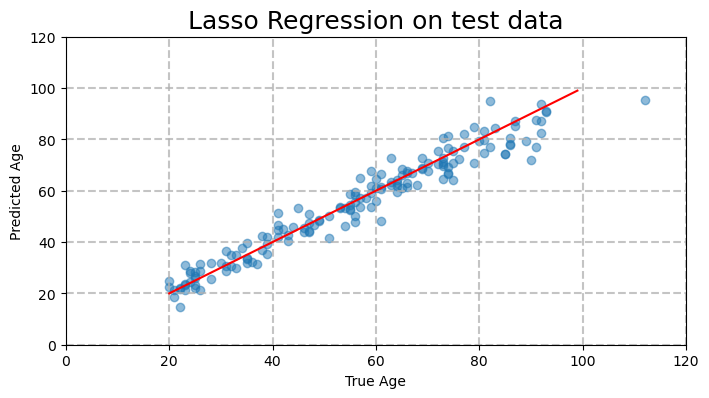

The MSE on Test data is 25.501 years
The rms on Test data is 5.050 years
The r^2 on Test data is 0.944
The mae on Test data is 3.707 years
The correlation on the Test data true-predicted is 0.973


In [36]:
preds, MSE, rms, r2, MAE, r_corr = rg.test_model_on_heldout_data(X_test_female, y_test_female, wb_mod_lasso_100, mtype='Lasso Regression', figsize=(8,4))

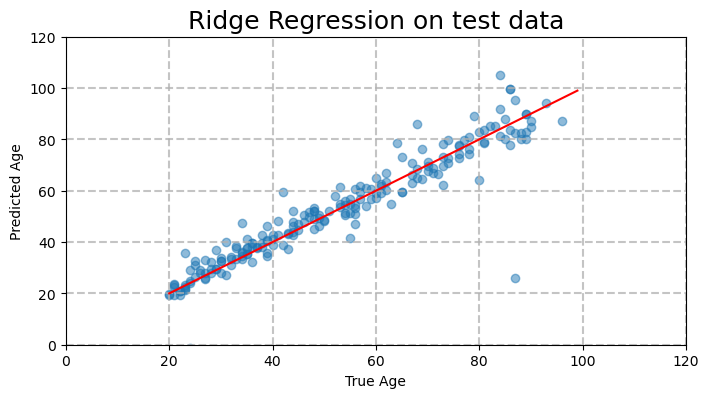

The MSE on Test data is 48.391 years
The rms on Test data is 6.956 years
The r^2 on Test data is 0.890
The mae on Test data is 4.088 years
The correlation on the Test data true-predicted is 0.945


In [38]:
preds, MSE, rms, r2, MAE, r_corr = rg.test_model_on_heldout_data(X_test_male, y_test_male, wb_mod_ridge_100, mtype='Ridge Regression', figsize=(8,4))

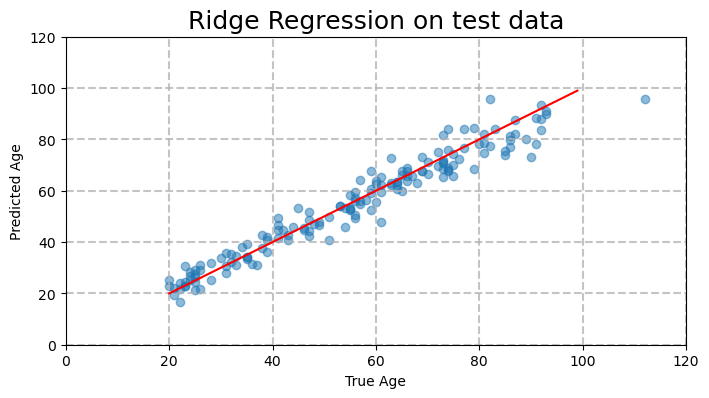

The MSE on Test data is 24.864 years
The rms on Test data is 4.986 years
The r^2 on Test data is 0.945
The mae on Test data is 3.740 years
The correlation on the Test data true-predicted is 0.974


In [39]:
preds, MSE, rms, r2, MAE, r_corr = rg.test_model_on_heldout_data(X_test_female, y_test_female, wb_mod_ridge_100, mtype='Ridge Regression', figsize=(8,4))